In [16]:
import os
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt

# 전역변수

In [36]:
# 전역 변수 설정
IMAGE_HEIGHT = 112
IMAGE_WIDTH = 92
FACE_COUNT = 10  # 사람 수
MAX_EIGENFACES = 20  # 생성할 총 eigenface 수

In [37]:
def load_raw_image(filepath):
    # 교수님이 주신 파일 불러오는 코드
    fid = open(filepath, "rb")
    face_image = np.reshape(np.fromfile(fid, dtype='uint8', sep=""), [112, 92])
    fid.close()
    return face_image

In [38]:
def load_dataset(data_dir):
    images = []
    labels = []
    filenames = []
    
    # 디렉토리 내의 모든 .raw 파일 찾기
    for filename in sorted(os.listdir(data_dir)):
        if filename.endswith('.raw'):
            person_id = int(filename.split('-')[0]) - 1
            
            # 이미지 로드
            img_path = os.path.join(data_dir, filename)
            img = load_raw_image(img_path)
            
            # 이미지, 라벨, 파일명 저장
            images.append(img.flatten())  # 1차원 벡터로 변환
            labels.append(person_id)
            filenames.append(filename)
    
    return np.array(images), np.array(labels), filenames

In [39]:
def compute_mean_face(faces):
    # 평균 얼굴
    return np.mean(faces, axis=0)

In [40]:
def compute_eigenfaces(faces, mean_face, num_components=MAX_EIGENFACES):
    # 평균 얼굴을 뺀 차이 행렬
    # 공분산 행렬 계산 X * X^T
    centered_faces_mat = faces - mean_face
    cov_matrix = np.dot(centered_faces_mat, centered_faces_mat.T)
    
    # eigenvalues와 eigenvectors 계산
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # 큰 eigenvalue 순으로 정렬 
    # eigenvalue가 크면 중요도가 높다는 뜻으로 이해함
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # 원래 차원으로 변환
    eigenfaces = np.dot(centered_faces_mat.T, eigenvectors)
    
    # 정규화
    for i in range(eigenfaces.shape[1]):
        eigenfaces[:, i] = eigenfaces[:, i] / np.linalg.norm(eigenfaces[:, i])
    
    return eigenfaces[:, :num_components]

In [41]:
def project_face(face, mean_face, eigenfaces):
    # 평균 얼굴을 뺀 테스트 이미지
    centered_face = face - mean_face
    
    # 얼굴을 eigenfaces 공간으로 투영
    return np.dot(centered_face, eigenfaces)

In [42]:
def reconstruct_face(projected_face, mean_face, eigenfaces):
    # 투영된 얼굴 재구성
    return mean_face + np.dot(projected_face, eigenfaces.T)

In [43]:
def recognize_face(test_face, train_faces, train_labels, mean_face, eigenfaces):
    # 테스트 얼굴을 eigenface 공간으로 투영
    test_projected = project_face(test_face, mean_face, eigenfaces)
    
    # 모든 학습 얼굴에 대한 투영
    train_projected = np.array([project_face(face, mean_face, eigenfaces) for face in train_faces])
    
    # 유클리드 거리 계산
    min_dist = float('inf')
    min_idx = -1
    
    for i, proj_face in enumerate(train_projected):
        dist = distance.euclidean(test_projected, proj_face)
        if dist < min_dist:
            min_dist = dist
            min_idx = i
    
    # 가장 가까운 얼굴의 라벨 반환
    return train_labels[min_idx]

In [44]:
# 얼굴 인식 정확도 평가
def evaluate_accuracy(train_faces, train_labels, test_faces, test_labels, mean_face, eigenfaces):
    correct = 0
    total = len(test_faces)
    
    for i, test_face in enumerate(test_faces):
        predicted_label = recognize_face(test_face, train_faces, train_labels, mean_face, eigenfaces)
        if predicted_label == test_labels[i]:
            correct += 1
    
    accuracy = (correct / total) * 100
    return accuracy


In [45]:
def split_data(faces, labels, train_ratio):
    # 각 사람별로 데이터 분할
    train_faces = []
    train_labels = []
    test_faces = []
    test_labels = []
    
    for person_id in range(FACE_COUNT):
        # 해당 사람의 얼굴 인덱스 찾기
        person_indices = np.where(labels == person_id)[0]
        
        # 학습용 데이터 수 계산
        num_train = int(len(person_indices) * train_ratio)
        
        # 무작위로 인덱스 섞기
        np.random.shuffle(person_indices)
        
        # 학습용과 테스트용으로 분할
        train_indices = person_indices[:num_train]
        test_indices = person_indices[num_train:]
        
        # 데이터 추가
        train_faces.extend(faces[train_indices])
        train_labels.extend(labels[train_indices])
        test_faces.extend(faces[test_indices])
        test_labels.extend(labels[test_indices])
    
    return np.array(train_faces), np.array(train_labels), np.array(test_faces), np.array(test_labels)


학습/테스트 비율: 1:9
eigen faces 1 = 37.77777777777778 %
eigen faces 3 = 68.88888888888889 %
eigen faces 5 = 82.22222222222221 %
eigen faces 7 = 92.22222222222223 %
eigen faces 9 = 90.0 %

학습/테스트 비율: 2:8
eigen faces 1 = 41.25 %
eigen faces 3 = 87.5 %
eigen faces 5 = 90.0 %
eigen faces 7 = 91.25 %
eigen faces 9 = 95.0 %

학습/테스트 비율: 3:7
eigen faces 1 = 38.57142857142858 %
eigen faces 3 = 80.0 %
eigen faces 5 = 90.0 %
eigen faces 7 = 95.71428571428572 %
eigen faces 9 = 95.71428571428572 %

학습/테스트 비율: 4:6
eigen faces 1 = 33.33333333333333 %
eigen faces 3 = 73.33333333333333 %
eigen faces 5 = 86.66666666666667 %
eigen faces 7 = 93.33333333333333 %
eigen faces 9 = 96.66666666666667 %

학습/테스트 비율: 5:5
eigen faces 1 = 42.0 %
eigen faces 3 = 90.0 %
eigen faces 5 = 92.0 %
eigen faces 7 = 92.0 %
eigen faces 9 = 96.0 %

학습/테스트 비율: 6:4
eigen faces 1 = 55.00000000000001 %
eigen faces 3 = 70.0 %
eigen faces 5 = 87.5 %
eigen faces 7 = 92.5 %
eigen faces 9 = 97.5 %

학습/테스트 비율: 7:3
eigen faces 1 = 46.66666666

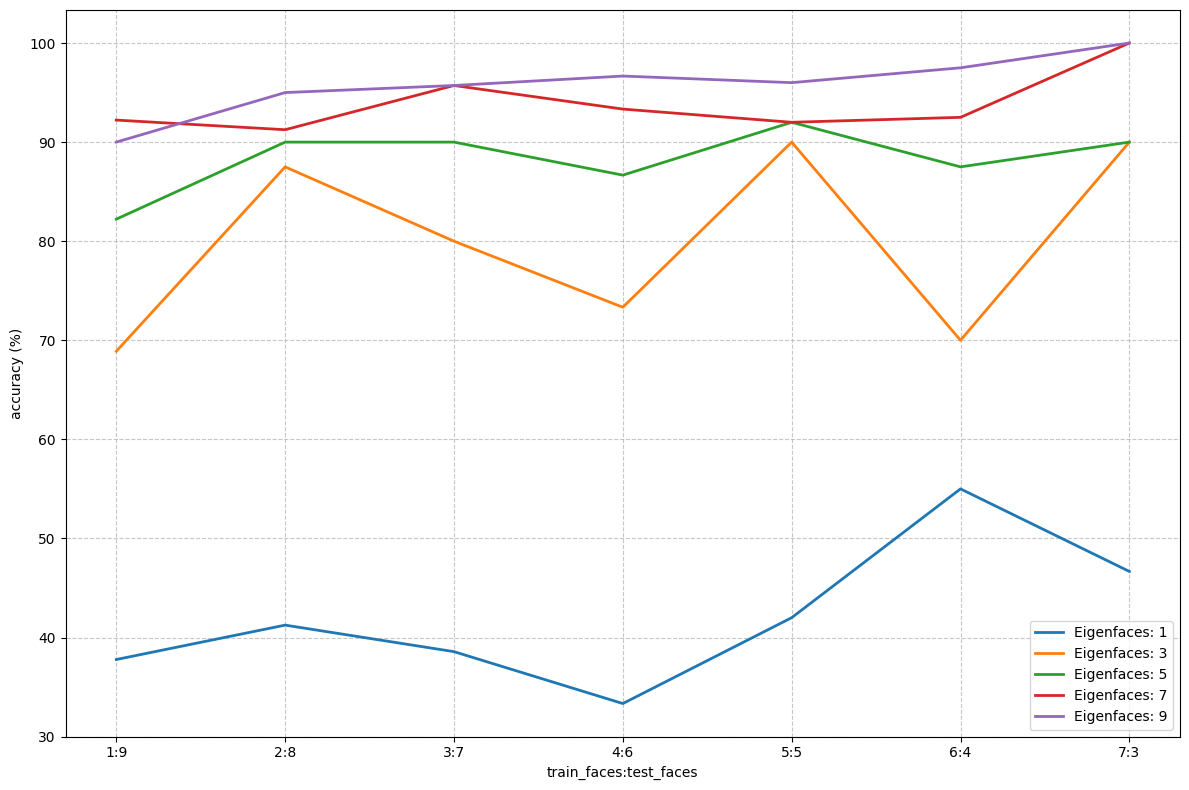

In [46]:
data_dir = "image_dataset"

faces, labels, filenames = load_dataset(data_dir)

# 정확도 테이블 생성을 위한 비율 및 eigenface 개수 설정
ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
eigenface_nums = [1, 3, 5, 7, 9]

# 결과 테이블
results = np.zeros((len(eigenface_nums), len(ratios)))

# 각 조합에 대해 정확도 측정
for j, ratio in enumerate(ratios):
    print(f"\n학습/테스트 비율: {int(ratio*10)}:{int((1-ratio)*10)}")
    
    train_faces, train_labels, test_faces, test_labels = split_data(faces, labels, ratio)
    mean_face = compute_mean_face(train_faces)
    
    # 각 eigenface 개수에 대해 정확도 측정
    for i, num_components in enumerate(eigenface_nums):
        # Eigenfaces 계산
        eigenfaces = compute_eigenfaces(train_faces, mean_face, num_components)
        
        # 특정 비율과 eigenface 개수에 대한 정확도 평가
        accuracy = evaluate_accuracy(
            train_faces, train_labels, test_faces, test_labels,
            mean_face, eigenfaces
        )
        
        # 결과 저장
        results[i, j] = accuracy
        
        print(f"eigen faces {num_components} = {accuracy} %")
        
# ---------결과를 시각적으로 보여주기---------

print("\n결과:")
print("\t1:9\t2:8\t3:7\t4:6\t5:5\t6:4\t7:3")
for i, num_components in enumerate(eigenface_nums):
    result_line = f"{num_components}\t"
    for j in range(len(ratios)):
        result_line += f"{results[i, j]:.1f}%\t"
    print(result_line)

# 정확도 결과를 그래프로 시각화
plt.figure(figsize=(12, 8))

# 각 eigenface 개수별 선 그래프
for i, num_components in enumerate(eigenface_nums):
    plt.plot(
        [f"{int(r*10)}:{int((1-r)*10)}" for r in ratios], 
        results[i], 
        linewidth=2, 
        label=f'Eigenfaces: {num_components}'
    )

plt.xlabel('train_faces:test_faces')
plt.ylabel('accuracy (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()
